# In this notebook, we will examine key economic indicators from the *Federal Reserve Economic Database*, including *GDP, CPI (inflation), Employment, Interest Rates*, and other relevant factors. We will also be using time series methods like *ARIMA and SARIMA* models to make forecasts in the future

# EDA

## We will start by looking at both GDP and GDP Per. Capita

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import plotly.express as px
from statsmodels.tsa.stattools import adfuller 
import sys
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm 
from datetime import timedelta
import datetime
from dotenv import load_dotenv
import os
import contextily as ctx
import pmdarima as pm


# plt.style.use('seaborn-v0_8-colorblind')
import us
import fredapi as fd
from fredapi import Fred
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

In [2]:
# Access Fred Key
load_dotenv('file.env')

fred_key = os.getenv("FRED_API_KEY")
#print(fred_key)

fred = Fred(api_key=fred_key)

In [3]:
gdp = fred.get_series('GDP')

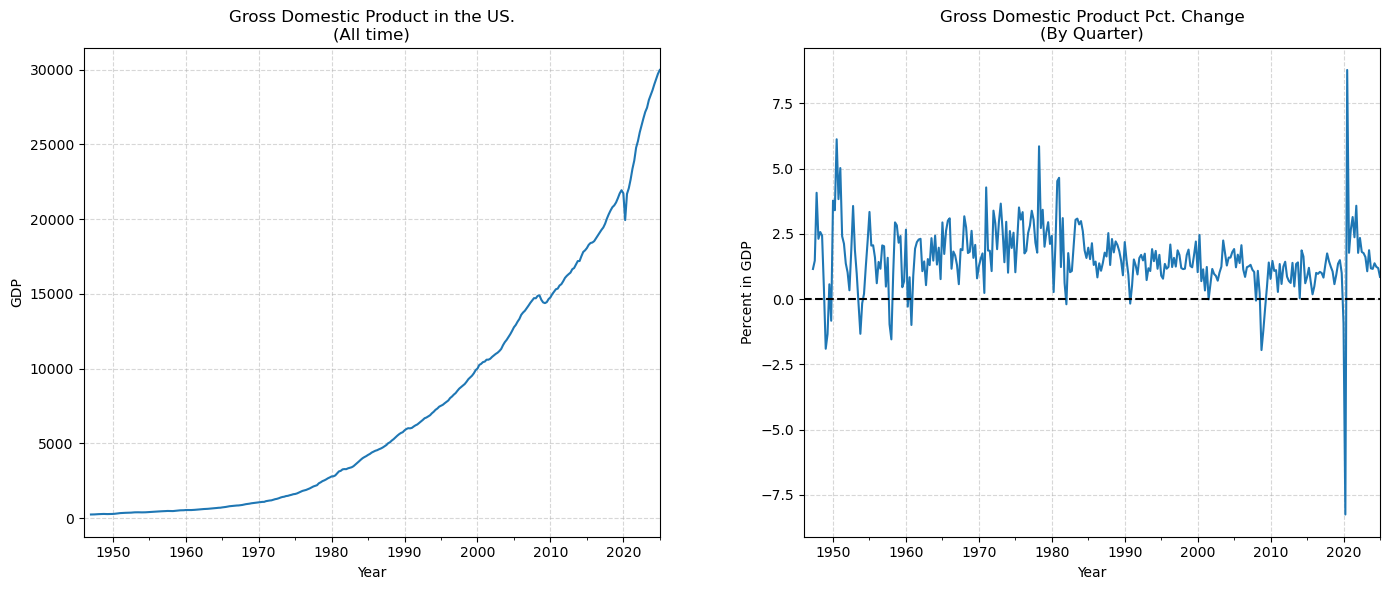

In [4]:
# Lets observe GDP
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

# Alltime GDP
gdp.plot(
    ax=ax[0],
    title = "Gross Domestic Product in the US.\n(All time)",
    legend=False
)

ax[0].set_xlabel("Year"); ax[0].set_ylabel("GDP")

# Pct_change in gdp
#print(gdp.pct_change())

(gdp.pct_change()*100).plot(
    ax=ax[1],
    title="Gross Domestic Product Pct. Change\n(By Quarter)"
)
ax[1].axhline(y = 0, color = 'k', linestyle = '--')
ax[1].set_xlabel("Year"); ax[1].set_ylabel("Percent in GDP")

ax[0].grid(linestyle='--', alpha = 0.5); ax[1].grid(linestyle='--', alpha = 0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

## Lets now look at inflation data

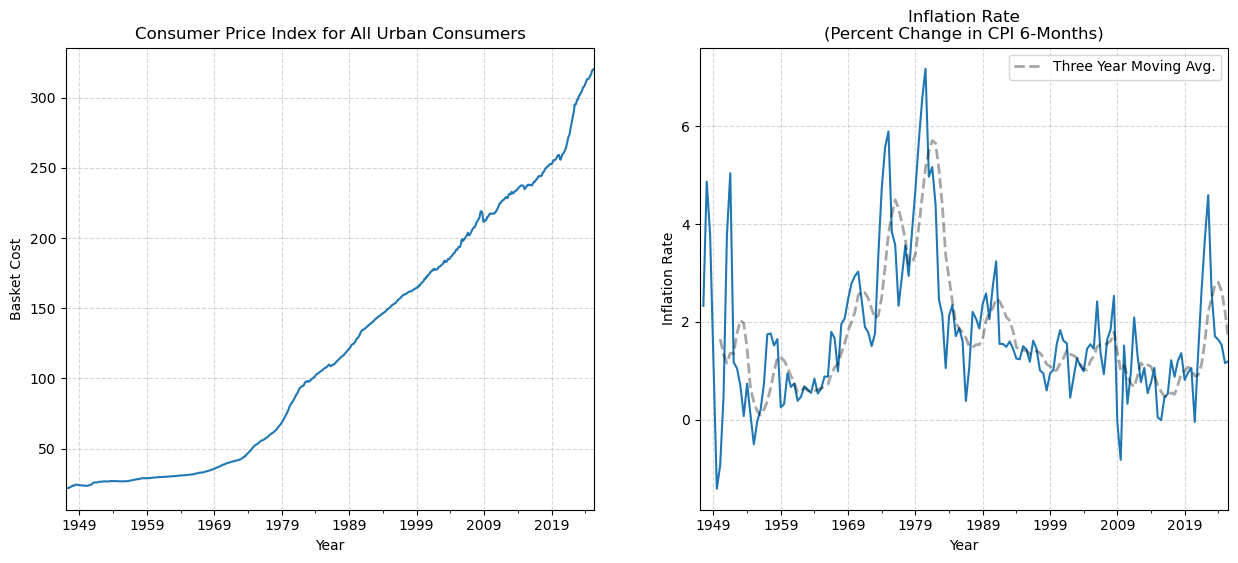

In [5]:
cpi = fred.get_series("CPIAUCSL")

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
cpi.plot(
    ax=ax[0],
    title = "Consumer Price Index for All Urban Consumers"
)

ax[0].set_xlabel("Year"); ax[0].set_ylabel("Basket Cost")

#6-month inflation rate
(cpi.resample('6M').mean().pct_change()*100).plot(
    ax=ax[1],
    title = "Inflation Rate\n(Percent Change in CPI 6-Months)"
)

#6-month inflation rates yearly average
(cpi.resample('6M').mean().pct_change()*100).rolling(window = 6).mean().plot(
    ax=ax[1],
    color = 'k',
    label = "Three Year Moving Avg.",
    linewidth = 2,
    linestyle = '--',
    alpha = 0.35
)

ax[1].legend()
ax[1].set_xlabel("Year"); ax[1].set_ylabel("Inflation Rate")

ax[0].grid(linestyle='--', alpha = 0.5); ax[1].grid(linestyle='--', alpha = 0.5)

plt.show()

## Lets see how the biggest expense has change over time: housing

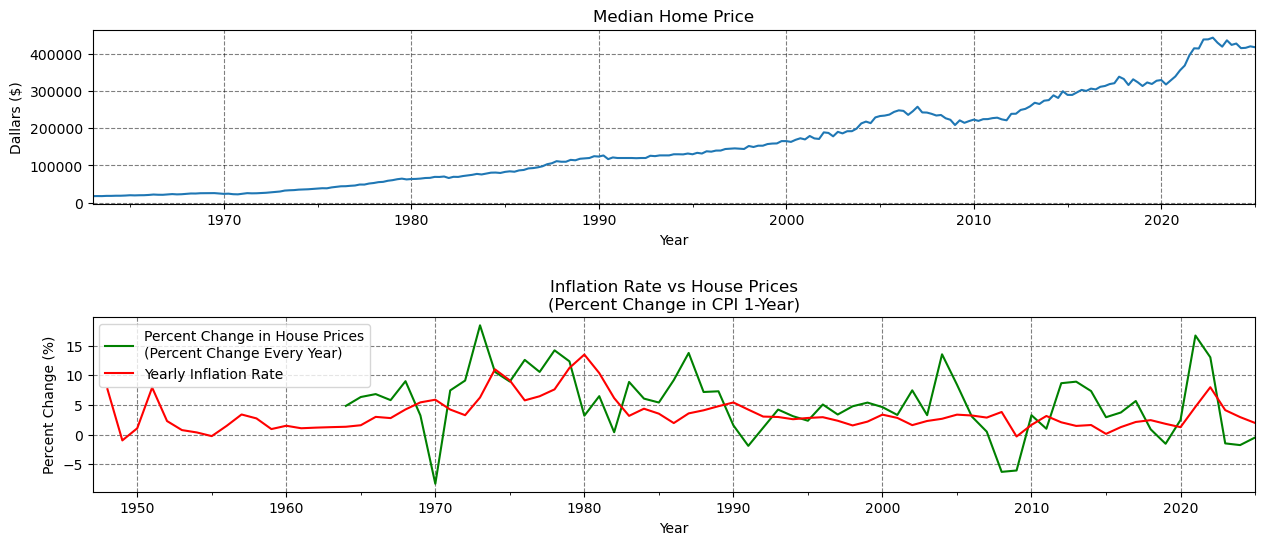

In [6]:
# House Price data
house_price = fred.get_series('MSPUS')

# Figure
fig, ax = plt.subplots(2, 1, figsize = (6, 18))

# Median Home Price over time
house_price.plot(
    title = "Median Home Price",
    xlabel = "Year",
    ylabel = "Dallars ($)",
    figsize=(15, 6),
    ax=ax[0]
)

ax[0].grid(alpha = 0.5, color = 'k', linestyle = '--')

(house_price.resample('A').mean().pct_change()*100).plot(ax=ax[1], label = "Percent Change in House Prices\n(Percent Change Every Year)", color = 'green')

#6-month inflation rate
(cpi.resample('A').mean().pct_change()*100).plot(
    ax=ax[1],
    title = "Inflation Rate vs House Prices\n(Percent Change in CPI 1-Year)",
    color = 'red',
    label = "Yearly Inflation Rate"
)


ax[1].set_xlabel("Year"); ax[1].set_ylabel("Percent Change (%)")

ax[1].grid(alpha = 0.5, color = 'k', linestyle = '--')
ax[1].legend()

plt.subplots_adjust(hspace=0.65)

# Income

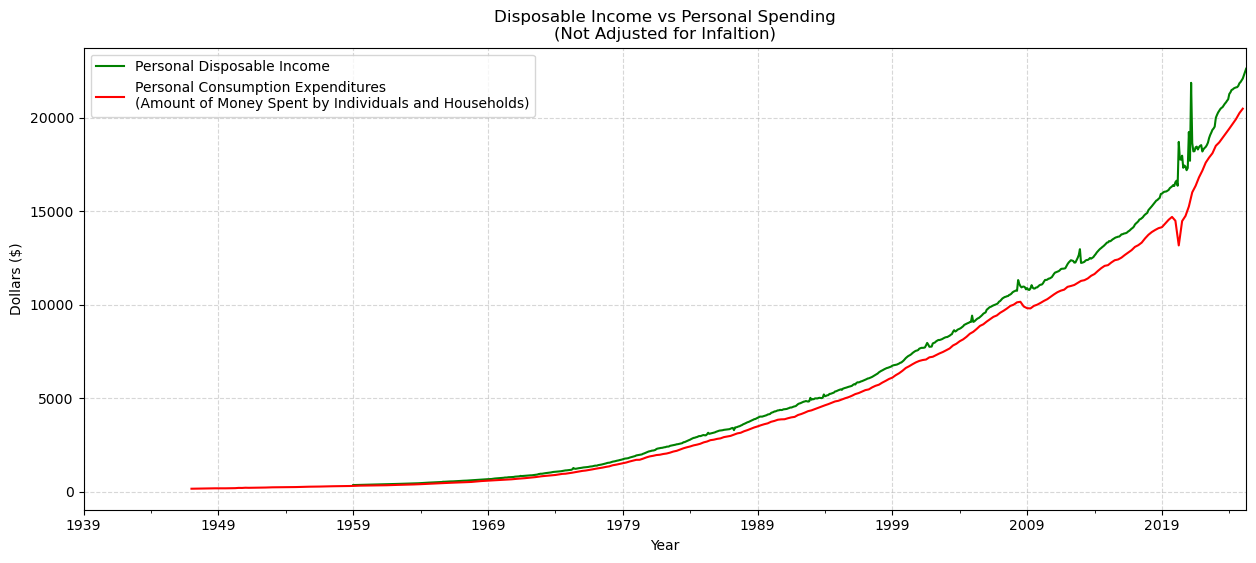

In [7]:
# Plot income vs Spending
pers_income = fred.get_series("DSPI")

plt.figure(figsize=(15, 6))

# Income
l1 = pers_income.plot(label = "Personal Disposable Income", color='green')

# Spending(PCE)
pce = fred.get_series('PCEC')
l2 = pce.plot(label = "Personal Consumption Expenditures\n(Amount of Money Spent by Individuals and Households)", color = 'red')

# Labels
plt.title("Disposable Income vs Personal Spending\n(Not Adjusted for Infaltion)")
plt.xlabel("Year"); plt.ylabel("Dollars ($)")


plt.legend()
plt.grid(linestyle = '--', alpha=0.5)

plt.show()

## Lets look at data for specific demographic

In [8]:
# College vs High School
income_college = fred.get_series('LEU0252918500Q').resample('A').mean()
income_no_college = fred.get_series('LEU0252917300Q').resample('A').mean()

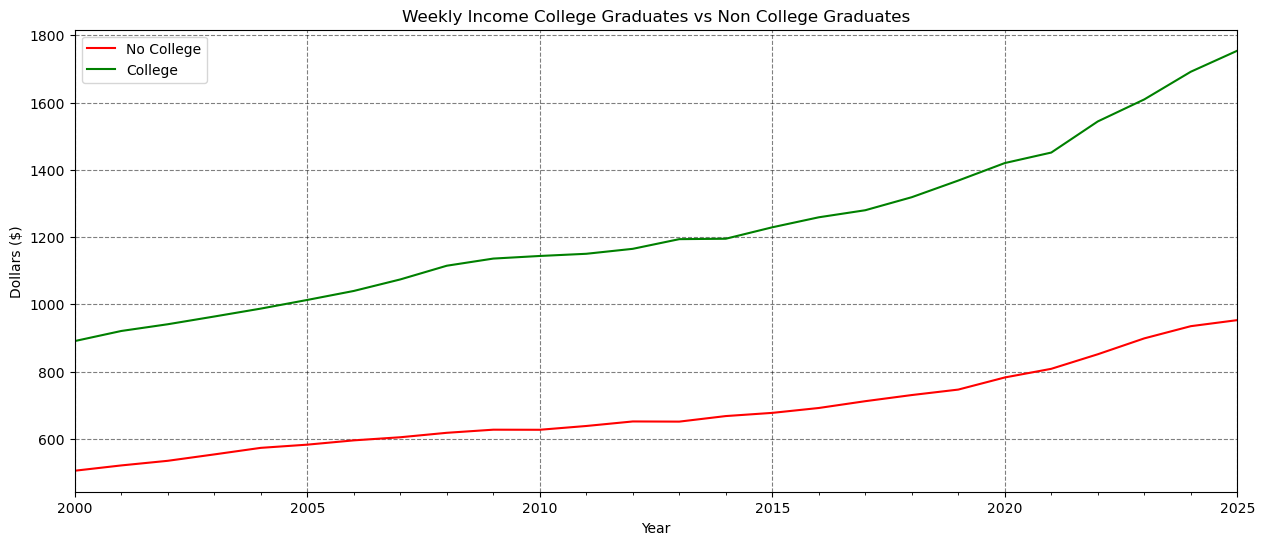

In [9]:
# Plot college vs no college annual salaries
salaries = pd.concat([income_college, income_no_college], axis=1)
salaries.columns = ["income_college", "income_no_college"]
salaries = salaries[["income_no_college", "income_college"]]

salaries.plot(figsize=(15, 6), color=['red', 'green'], title = "Weekly Income College Graduates vs Non College Graduates", label = ["No College", "College"])


plt.xlabel("Year"); plt.ylabel("Dollars ($)")
plt.legend(labels = ["No College", "College"])
plt.grid(alpha = 0.5, color = 'k', linestyle = '--')
plt.show()

### Lets look at minimum wage data aswell, by state

In [10]:
# # Apply this to the gdf to ensure all states are assigned colors by the same func
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

# Function will be used for plotting maps

In [11]:
# Some states dont have minimum wage
# state_no_minwg = ['Alabama', 'Louisiana', 'Mississippi', 'South Carolina', 'Tennessee']

# # Instantiate Data
# data = []

# # Scrape data
# states = [str(s) for s in us.states.STATES] # Us states
# for state in states:
#     # If state dosnt have minwg
#     if state in state_no_minwg:
#         data.append((state, np.nan))
#         continue

#     st = "STTMINWG" + us.states.lookup(state).abbr

#     temp_data = fred.get_series(st)[-1]

#     data.append((state, temp_data))

# ------------ ^ Data Scraping 

In [12]:
# Save data
#state_mnwg = pd.DataFrame(data, columns = ["State", "Wage"])
#state_mnwg.to_csv('state_minimum_wage.csv', index = False)

state_mnwg = pd.read_csv('state_minimum_wage.csv')
state_mnwg.head()

,State,Wage
0,Alabama,NaN
1,Alaska,11.91
2,Arizona,14.70
3,Arkansas,11.00
4,California,16.50


In [13]:
# Download and read in Geopandas/Shape data
us_states = gpd.read_file("https://raw.githubusercontent.com/jgoodall/us-maps/master/geojson/state.geo.json")[["NAME10", "geometry"]]

In [14]:
# Convert to geopandas
state_mnwg_geo = state_mnwg.merge(us_states, how='left', left_on = 'State', right_on='NAME10')
state_mnwg_geo = state_mnwg_geo[["State", "Wage", "geometry"]]

state_mnwg_geo = gpd.GeoDataFrame(
    state_mnwg_geo,
    geometry = state_mnwg_geo.geometry,
    crs="EPSG:4326"
)

C:\Users\ggpal\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\ggpal\AppData\Local\Temp\ipykernel_25512\3771584784.py:91: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


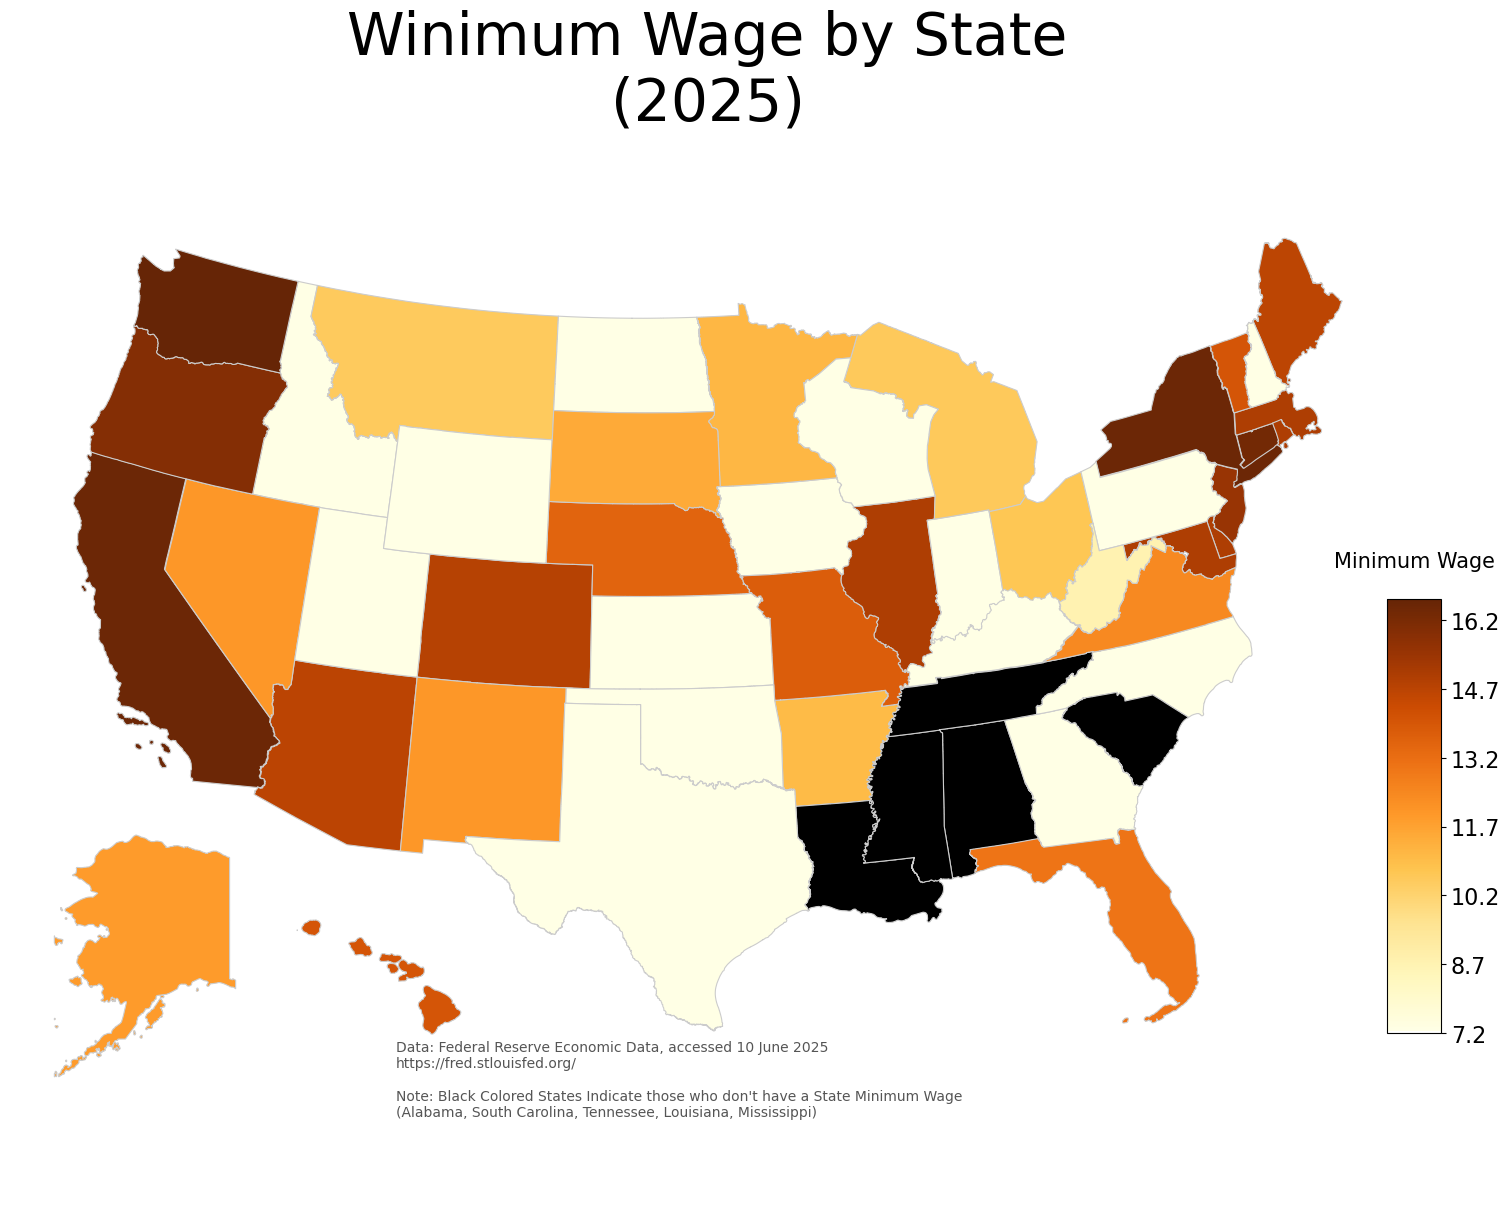

In [15]:
# **************************
# set the value column that will be visualised
variable = 'Wage'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = state_mnwg_geo.Wage.min(), state_mnwg_geo.Wage.max() #math.ceil(gdf.pct_food_insecure.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "YlOrBr"
gdf = makeColorColumn(state_mnwg_geo,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')


# add a title and annotation
ax.set_title('Winimum Wage by State\n(2025)\n', fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Minimum Wage\n', fontdict={'fontsize': '15', 'fontweight' : '0'})

# # add color scale
# sm = plt.cm.ScalarMappable(cmap=colormap, \
#                  norm=plt.Normalize(vmin=vmin, vmax=vmax))
# # reformat tick labels on legend
# sm._A = []
# comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
# fig.colorbar(sm, cax=cbax, format=comma_fmt)
# tick_font_size = 16
# cbax.tick_params(labelsize=tick_font_size)


# Custom tick locations (example: every 0.5 from vmin to vmax)
ticks = np.arange(round(vmin, 1), round(vmax + 1, 1), 1.5)

# Create ScalarMappable
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

# Format to show percentage
#percent_fmt = FuncFormatter(lambda x, _: f"{x:.1f}%")

# Add colorbar with formatted ticks
cbar = fig.colorbar(sm, cax=cbax)
cbar.set_ticks(ticks)

cbax.tick_params(labelsize=16)


# annotate the data source, date of access, and hyperlink
ax.annotate("Data: Federal Reserve Economic Data, accessed 10 June 2025\nhttps://fred.stlouisfed.org/\n\nNote: Black Colored States Indicate those who don't have a State Minimum Wage\n(Alabama, South Carolina, Tennessee, Louisiana, Mississippi)", xy=(0.22, .08), xycoords='figure fraction', fontsize=10, color='#555555')


# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.State not in ['Alaska','Hawaii']:
        vf = visframe[visframe.State==row.State]
        c = gdf[gdf.State==row.State][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

#ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)


# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.State=='Alaska']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.State=='Alaska'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.State=='Hawaii']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


plt.show()

## Employment Data

In [16]:
# Labor Force Participation Rate
lfpr = fred.get_series('CIVPART')

# Unemployment(U3) Rate
unemp = fred.get_series('UNRATE')

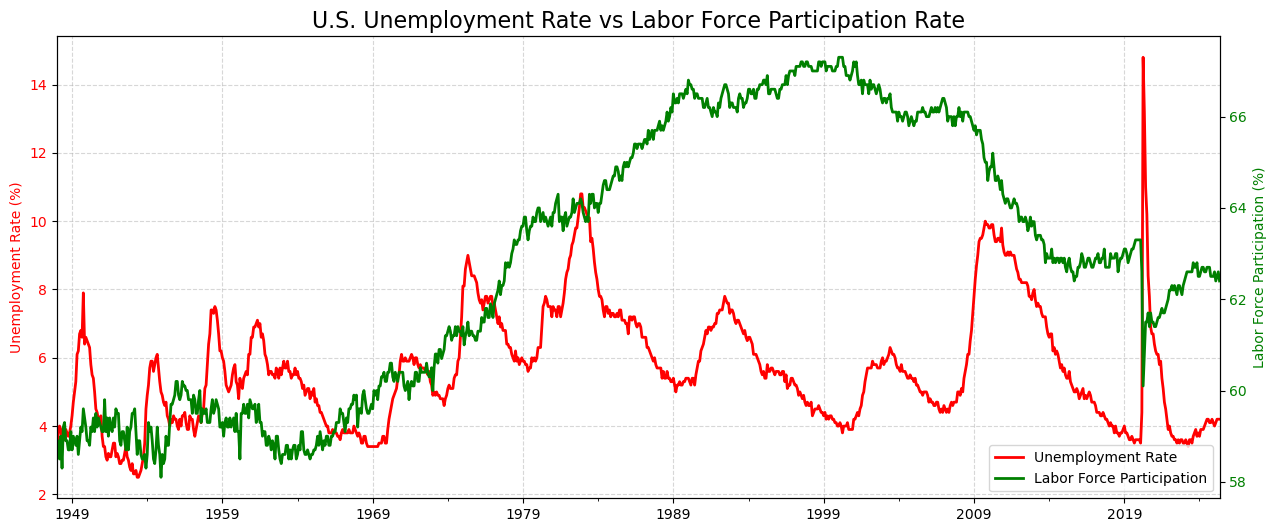

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Plot Unemployment Rate
unemp.plot(
    ax=ax,
    color='red',
    label='Unemployment Rate',
    linewidth=2
)
ax.set_ylabel('Unemployment Rate (%)', color='red')
ax.tick_params(axis='y', labelcolor='red')

# Twin axis for LFPR
ax2 = ax.twinx()
lfpr.plot(
    ax=ax2,
    color='green',
    label='Labor Force Participation',
    linewidth=2
)
ax2.set_ylabel('Labor Force Participation (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and grid
ax.set_title('U.S. Unemployment Rate vs Labor Force Participation Rate', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.5)

# Unified legend
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right')

plt.show()

## Lets continue to look at unemployment between different demographics

In [18]:
# College Grads vs High School Grads(no college)
unemp_college = fred.get_series('CGBD2534')
unemp_no_college = fred.get_series('LNS14027660')


# Demographics
unemp_white = fred.get_series('LNS14000003')
unemp_black = fred.get_series('LNS14000006')
unemp_lation = fred.get_series('LNS14000009')
unemp_asian = fred.get_series('LNU04032183')


# Gender 
unemp_male = fred.get_series('LNS14000001')
unemp_female = fred.get_series('LNS14000002')


# Age 
unemp_16_24 = fred.get_series('LNS14024887')
unemp_25_54 = fred.get_series('LNS14000060')
unemp_55 = fred.get_series('LNS14024230')

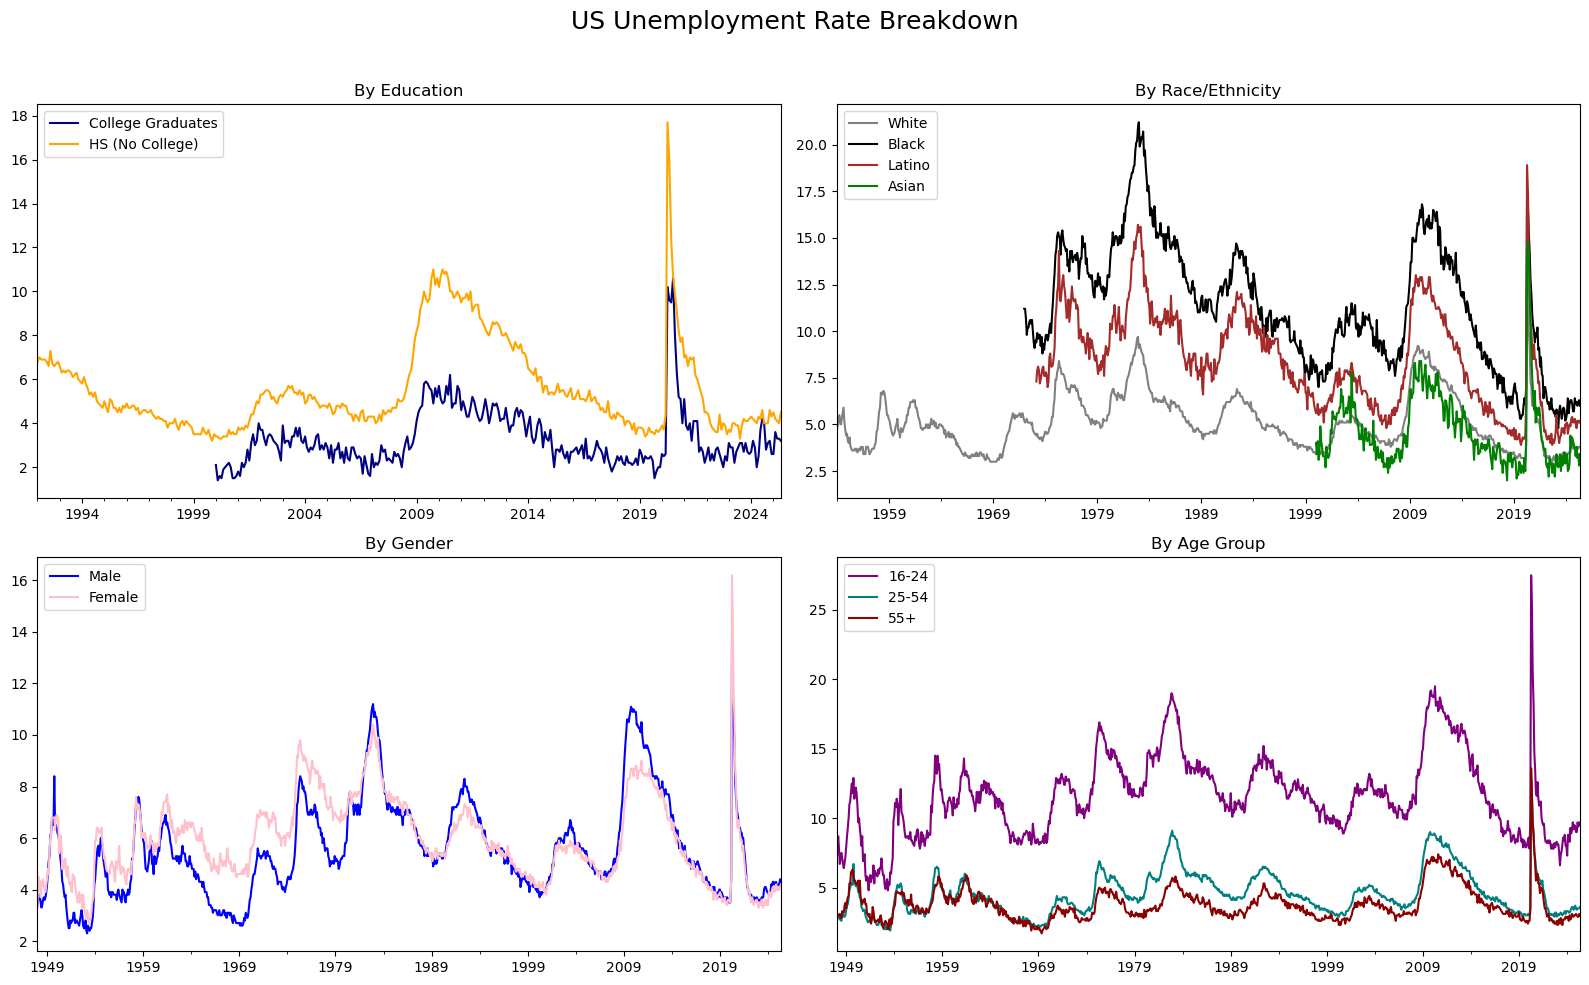

In [19]:
# Plot Unemployment based off of demographics
# Setup 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("US Unemployment Rate Breakdown", fontsize=18)

# Education
unemp_college.plot(ax=axes[0, 0], label="College Graduates", color='navy')
unemp_no_college.plot(ax=axes[0, 0], label="HS (No College)", color='orange')
axes[0, 0].set_title("By Education")
axes[0, 0].legend()

# Demographics
unemp_white.plot(ax=axes[0, 1], label="White", color='gray')
unemp_black.plot(ax=axes[0, 1], label="Black", color='black')
unemp_lation.plot(ax=axes[0, 1], label="Latino", color='brown')
unemp_asian.plot(ax=axes[0, 1], label="Asian", color='green')
axes[0, 1].set_title("By Race/Ethnicity")
axes[0, 1].legend()

# Gender
unemp_male.plot(ax=axes[1, 0], label="Male", color='blue')
unemp_female.plot(ax=axes[1, 0], label="Female", color='pink')
axes[1, 0].set_title("By Gender")
axes[1, 0].legend()

# Age
unemp_16_24.plot(ax=axes[1, 1], label="16-24", color='purple')
unemp_25_54.plot(ax=axes[1, 1], label="25-54", color='teal')
unemp_55.plot(ax=axes[1, 1], label="55+", color='darkred')
axes[1, 1].set_title("By Age Group")
axes[1, 1].legend()

# Clean layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [20]:
states = [str(state) for state in us.states.STATES]

In [21]:
# # Plot map with unemployment by state(2025)
# states_unemp = []

# i = 0
# for state in states:
#     # st = f'Unemployment Rate in {state}'
#     # search = fred.search(st)

#     # # Query Search results
#     # results = search.query('title == @st').reset_index()
#     # results = results[results['series id'].str.upper().str.endswith('UR')]
    
#     # if not (results.empty):
#     #     i+=1
#     #     print(i)
    
#     # print();
    
#     # temp = fred.get_series(results['series id'])
#     print(f"Loading {state}...")
    
#     st = us.states.lookup(state).abbr + 'UR'
#     state_data = fred.get_series(st).resample('A').mean()[-2:].mean() # Average Unemployment 2024-25

#     states_unemp.append((state, state_data))
#     print("Completed ✅")

# print(states_unemp)
# ------ Above Shows How Data Was Scraped


In [22]:
#states_unemp = pd.DataFrame(states_unemp, columns = ["State", "unemp_2025"])
#states_unemp.to_csv('states_unemp_2025.csv')

states_unemp = pd.read_csv('states_unemp_2025.csv')

In [23]:
# Convert to geopandas
us_states_geo = states_unemp.merge(us_states, how='left', left_on = 'State', right_on='NAME10')
us_states_geo = us_states_geo[["State", "unemp_2025", "geometry"]]

us_states_geo = gpd.GeoDataFrame(
    us_states_geo,
    geometry = us_states_geo.geometry,
    crs="EPSG:4326"
)

In [24]:
# # # Apply this to the gdf to ensure all states are assigned colors by the same func
# def makeColorColumn(gdf,variable,vmin,vmax):
#     # apply a function to a column to create a new column of assigned colors & return full frame
#     norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
#     mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
#     gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
#     return gdf

C:\Users\ggpal\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\ggpal\AppData\Local\Temp\ipykernel_25512\1071217846.py:93: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


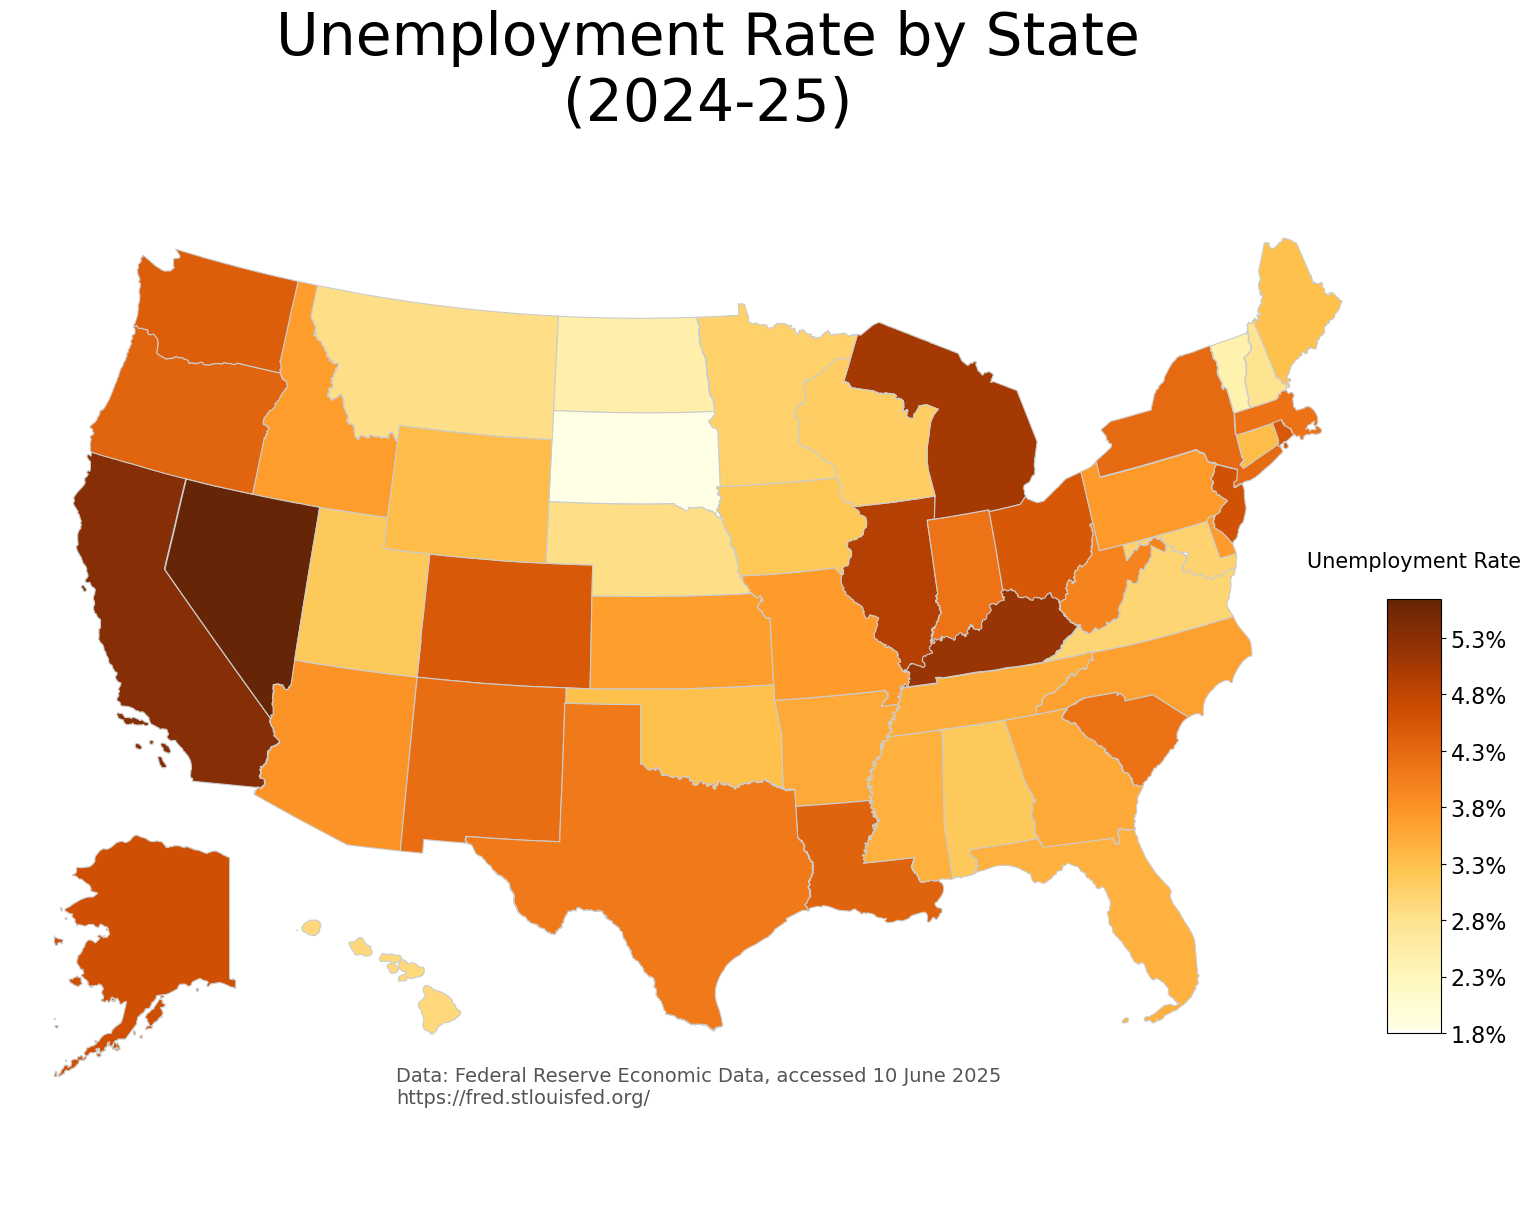

In [25]:
# **************************
# set the value column that will be visualised
variable = 'unemp_2025'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = us_states_geo.unemp_2025.min(), us_states_geo.unemp_2025.max() #math.ceil(gdf.pct_food_insecure.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "YlOrBr"
gdf = makeColorColumn(us_states_geo,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# set the font for the visualization to Helvetica
#hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Unemployment Rate by State\n(2024-25)\n', fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Unemployment Rate\n', fontdict={'fontsize': '15', 'fontweight' : '0'})

# # add color scale
# sm = plt.cm.ScalarMappable(cmap=colormap, \
#                  norm=plt.Normalize(vmin=vmin, vmax=vmax))
# # reformat tick labels on legend
# sm._A = []
# comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
# fig.colorbar(sm, cax=cbax, format=comma_fmt)
# tick_font_size = 16
# cbax.tick_params(labelsize=tick_font_size)


# Custom tick locations (example: every 0.5 from vmin to vmax)
ticks = np.arange(round(vmin, 1), round(vmax + 0.1, 1), 0.5)

# Create ScalarMappable
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

# Format to show percentage
percent_fmt = FuncFormatter(lambda x, _: f"{x:.1f}%")

# Add colorbar with formatted ticks
cbar = fig.colorbar(sm, cax=cbax, format=percent_fmt)
cbar.set_ticks(ticks)

cbax.tick_params(labelsize=16)


# annotate the data source, date of access, and hyperlink
ax.annotate("Data: Federal Reserve Economic Data, accessed 10 June 2025\nhttps://fred.stlouisfed.org/", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')


# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.State not in ['Alaska','Hawaii']:
        vf = visframe[visframe.State==row.State]
        c = gdf[gdf.State==row.State][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

#ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)


# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.State=='Alaska']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.State=='Alaska'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.State=='Hawaii']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


# Save img
fig.savefig(os.getcwd()+'/unemp_rate_24_25.png',dpi=400, bbox_inches="tight")


plt.show()

### As we can see, typically bigger states have higher unemployment. Lets do the same thing for Labor Force Participation

In [26]:
# # Data for avg LFPR
# data = []

# # Scrape LFPR
# for i, state in (enumerate(states, start = 1)):
#     print(f"Loading {state}...")

#     st = f"Labor Force Participation Rate for {state}"

#     # Search fred
#     search = fred.search(st).query('title == @st')
#     result = search[search['id'].str.startswith('LBSSA')]

#     #result = search[search['id'].str.startswith('LBSSA')]
#     print(result.index[0])

#     temp_data = fred.get_series(result.index[0]).resample('A').mean()[-2:].mean() # --2024-25 Mean
    
#     #temp_data = fred.get_series(result.index)
#     print(f"{state} completed ✅")
    
#     data.append((state, temp_data))

# ---- Scraping fred data ^

In [27]:
#state_lfpr = pd.DataFrame(data, columns = ["State", "LFPR"])
#state_lfpr.to_csv("labor_force_part.csv")
state_lfpr = pd.read_csv("labor_force_part.csv")[["State", "LFPR"]]

state_lfpr.head()

,State,LFPR
0,Alabama,57.625000
1,Alaska,64.779167
2,Arizona,61.495833
3,Arkansas,58.304167
4,California,62.125000


In [28]:
# Convert to geopandas
us_states_geo_lfpr = state_lfpr.merge(us_states, how='left', left_on = 'State', right_on='NAME10')
us_states_geo_lfpr = us_states_geo_lfpr[["State", "LFPR", "geometry"]]

us_states_geo_lfpr = gpd.GeoDataFrame(
    us_states_geo_lfpr,
    geometry = us_states_geo_lfpr.geometry,
    crs="EPSG:4326"
)

us_states_geo_lfpr.head()

,State,LFPR,geometry
0,Alabama,57.625000,"POLYGON ((-86.31127 34.9911, -86.30899 34.9910..."
1,Alaska,64.779167,"MULTIPOLYGON (((177.44593 52.11133, 177.44302 ..."
2,Arizona,61.495833,"POLYGON ((-109.04761 32.42638, -109.04762 32.4..."
3,Arkansas,58.304167,"POLYGON ((-94.55218 36.10224, -94.55219 36.102..."
4,California,62.125000,"MULTIPOLYGON (((-119.00093 33.5359, -119.00093..."


C:\Users\ggpal\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\ggpal\AppData\Local\Temp\ipykernel_25512\1146047998.py:92: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


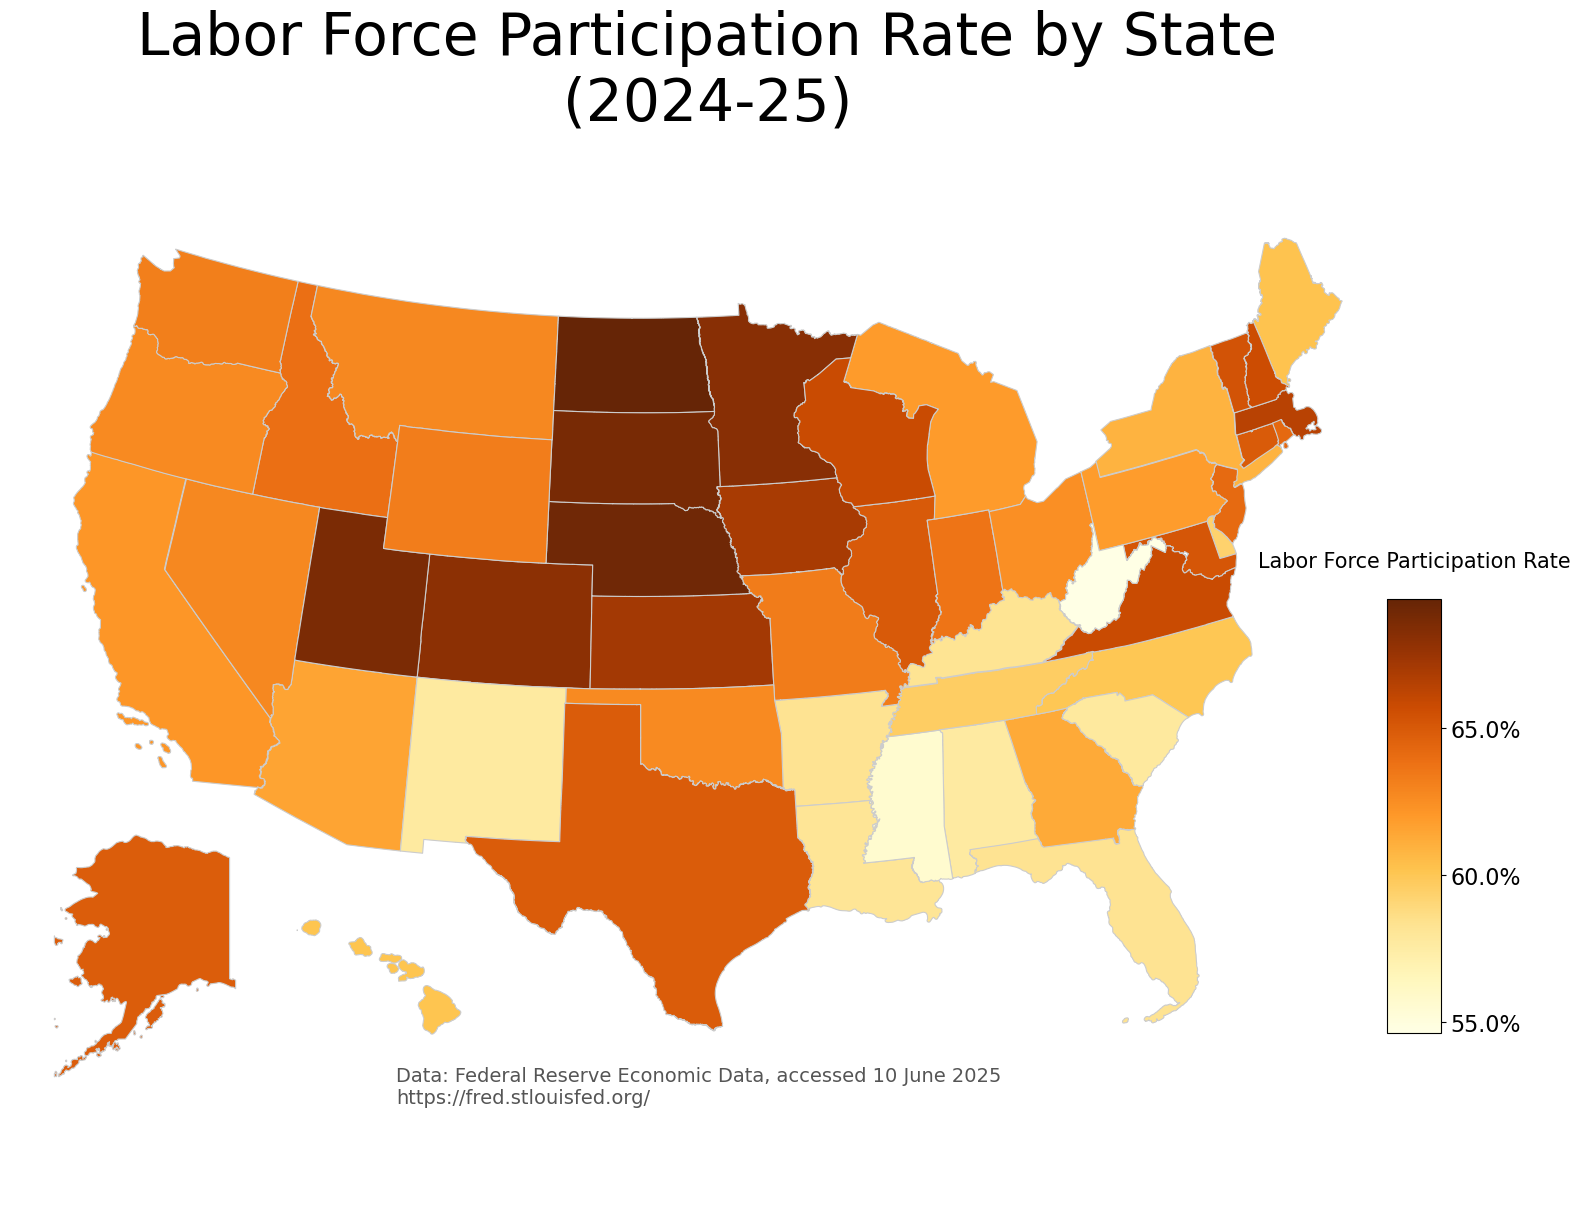

In [29]:
# **************************
# set the value column that will be visualised
variable = 'LFPR'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = us_states_geo_lfpr.LFPR.min(), us_states_geo_lfpr.LFPR.max() #math.ceil(gdf.pct_food_insecure.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "YlOrBr"
gdf = makeColorColumn(us_states_geo_lfpr,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# set the font for the visualization to Helvetica
#hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Labor Force Participation Rate by State\n(2024-25)\n', fontdict={'fontsize': '42', 'fontweight' : '1'})


# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Labor Force Participation Rate\n', fontdict={'fontsize': '15', 'fontweight' : '0'})

# # add color scale
# sm = plt.cm.ScalarMappable(cmap=colormap, \
#                  norm=plt.Normalize(vmin=vmin, vmax=vmax))
# # reformat tick labels on legend
# sm._A = []
# comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
# fig.colorbar(sm, cax=cbax, format=comma_fmt)
# tick_font_size = 16
# cbax.tick_params(labelsize=tick_font_size)


# Custom tick locations (example: every 0.5 from vmin to vmax)
ticks = np.arange(round(vmin), round(vmax + 1), 5)

# Create ScalarMappable
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

# Format to show percentage
percent_fmt = FuncFormatter(lambda x, _: f"{x:.1f}%")

# Add colorbar with formatted ticks
cbar = fig.colorbar(sm, cax=cbax, format=percent_fmt)
cbar.set_ticks(ticks)

cbax.tick_params(labelsize=16)


# annotate the data source, date of access, and hyperlink
ax.annotate("Data: Federal Reserve Economic Data, accessed 10 June 2025\nhttps://fred.stlouisfed.org/", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')


# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.State not in ['Alaska','Hawaii']:
        vf = visframe[visframe.State==row.State]
        c = gdf[gdf.State==row.State][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')


# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.State=='Alaska']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.State=='Alaska'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.State=='Hawaii']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')



# Save img
fig.savefig(os.getcwd()+'/lfpr_24_25.png',dpi=400, bbox_inches="tight")



plt.show()

## Regarding Employment, lets now look at jobs data

In [30]:
# Total nonfarm workers
nonfarm_total = fred.get_series('PAYEMS')

# Nonfarm job-openings --> Sample By Year
nonfarm_openings = fred.get_series('JTSJOL').resample('A').mean()

# Nonfarm quits & layoffs --> Sample By Year
nonfarm_quits_layoffs = (fred.get_series('JTSQUL').resample('A').mean()) + (fred.get_series('JTSLDL').resample('A').mean())

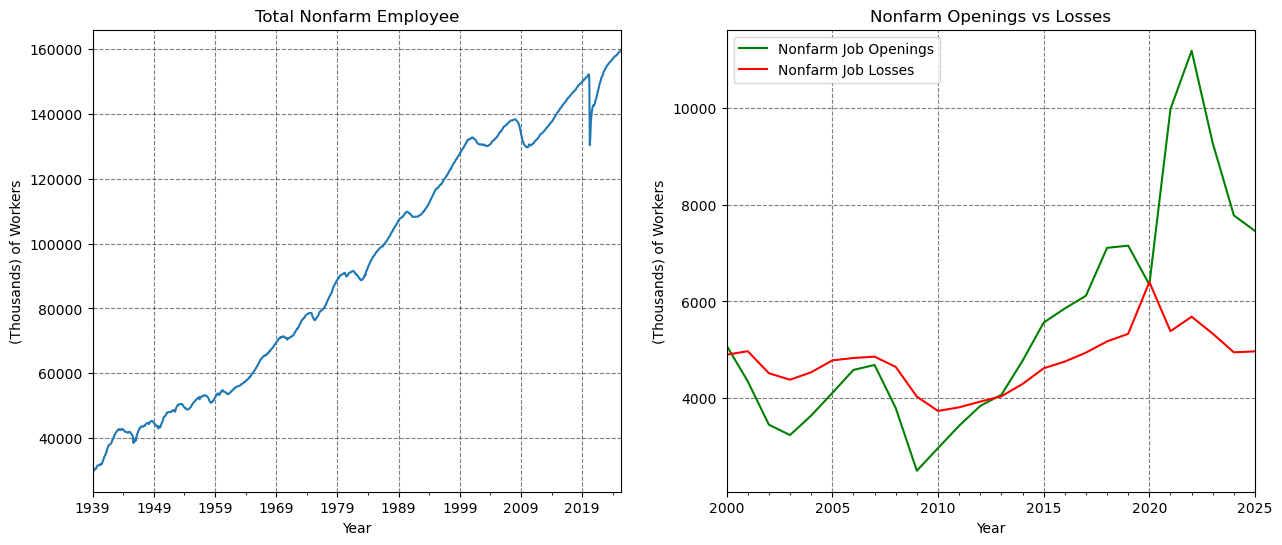

In [31]:
# Plot 
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Amount of workers
nonfarm_total.plot(
    ax = ax[0],
    title = "Total Nonfarm Employee",
    xlabel = "Year",
    ylabel = "(Thousands) of Workers"
)
ax[0].grid(alpha=0.5, color = 'k', linestyle = '--')

# Openings vs Closings
nonfarm_openings.plot(ax = ax[1], color = 'green', label = "Nonfarm Job Openings"); nonfarm_quits_layoffs.plot(ax=ax[1], color = 'red', label="Nonfarm Job Losses")
ax[1].set_title("Nonfarm Openings vs Losses")
ax[1].set_xlabel("Year"); ax[1].set_ylabel("(Thousands) of Workers")

ax[1].legend()
ax[1].grid(alpha=0.5, color = 'k', linestyle = '--')

# Time series. Now we will use time series methods like ARIMA and SARIMA models to project future Inflation and Unemployment(seasonal)

## Lets start by predicting inflation (Year-over-year)

In [32]:
# Step one check stationarity
inflation = (cpi.resample('A').mean().pct_change()*100).dropna()
print(f"Inflation Data Adfuller Test 1:\n{adfuller(inflation)}")

Inflation Data Adfuller Test 1:
(-2.3072765377834132, 0.16963188225479336, 2, 75, {'1%': -3.520713130074074, '5%': -2.9009249540740742, '10%': -2.5877813777777776}, 247.29717831516356)


### p-value is 0.17, which is great than 0.05. This means we cannot reject the null hypothesis that the data is stationary. THis means the data will require differencing. Lets check if the differenced form is stationary

In [33]:
inflation_diff = inflation.diff().dropna()
adfuller(inflation_diff)

(-10.09033420887224,
 1.126575876598956e-17,
 1,
 75,
 {'1%': -3.520713130074074,
  '5%': -2.9009249540740742,
  '10%': -2.5877813777777776},
 247.2322470937998)

In [34]:
adfuller(inflation_diff)[1] < 0.05

True

### The p-value for the differnced data is quite well below 0.05, so we can reject the null-hypothesis that the data is stationary. Now, to find the optimal model, we will use acf and pacf plots to see the datas behavior

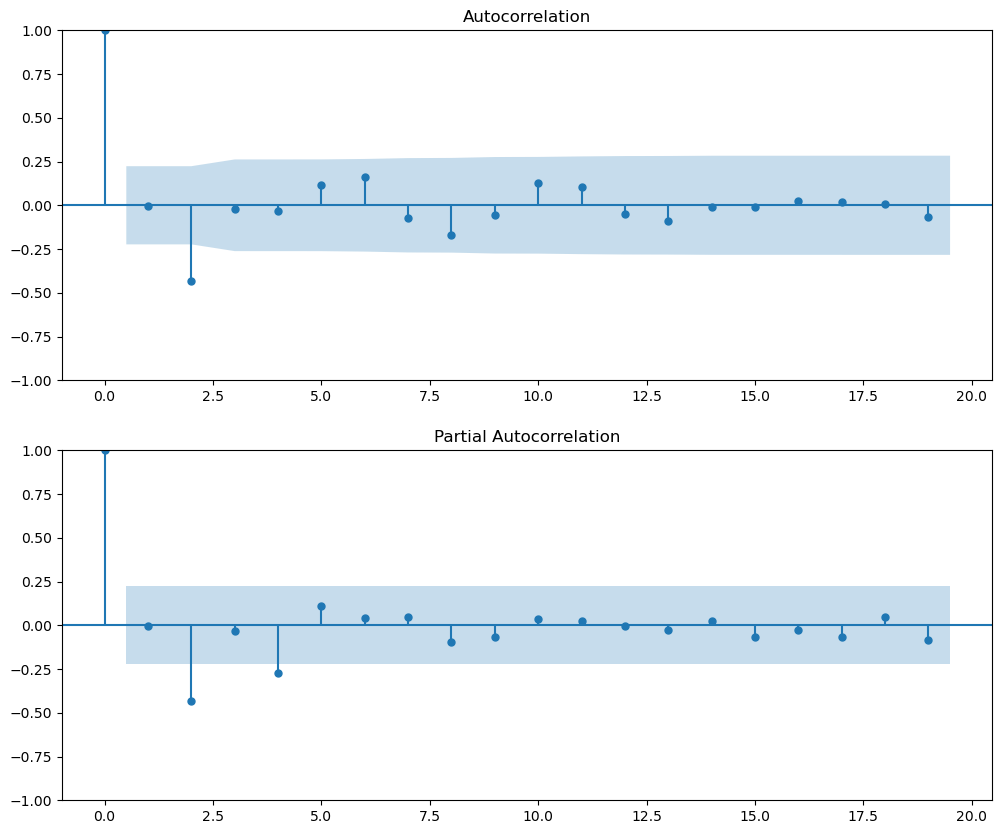

In [35]:
# Plot both pacf and acf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10))


plot_acf(inflation_diff, ax = ax1) # Plot act
plot_pacf(inflation_diff, ax=ax2) # Plot pacf

plt.subplots_adjust(hspace=0.2)
plt.show()

In [36]:
# Lets look at AIC and BIC
data = []

 # Loop over AR order 
for p in range(6): 
    # Loop over MA order 
    for q in range(6): 
        try: 
            # Fit model 
            model = ARIMA(inflation_diff, order=(p,0,q)) 
            results = model.fit() 
 
            # Print the model order and the AIC/BIC values 
            data.append((p, q, results.aic, results.bic))
        except: 
            # Print AIC and BIC as None when fails
            print(p, q, None, None) 

aic_bic_df = pd.DataFrame(data, columns = ['p', 'q', 'AIC', 'BIC'])

C:\Users\ggpal\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ggpal\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ggpal\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ggpal\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ggpal\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [37]:
# Find params with both low AIC and BIC
low_aic_ind = aic_bic_df.sort_values(by = 'AIC').head(10).index
low_bic_ind = aic_bic_df.sort_values(by = 'BIC').head(10).index

# Best Index Params Based soley off of aic & bic
valid_mdls_ind = list(set(low_aic_ind) & set(low_bic_ind))

# Best params df
best_params = aic_bic_df.iloc[valid_mdls_ind, :]
best_params

,p,q,AIC,BIC
24,4,0,324.783954,338.846786
2,0,2,324.315813,333.691035
26,4,2,322.705034,341.455477


### Given all of this information, lets see which model bests fits the data

In [38]:
# Min RMSE
min_rmse = sys.maxsize
index = None
main_row = None

# Loop through model parameters
for i, row in best_params.iterrows():
    temp_mdl = ARIMA(inflation, order=(row['p'], 1, row['q'])).fit()
    temp_rmse = np.sqrt(np.mean(temp_mdl.resid ** 2))

    # Minimize RMSE
    if temp_rmse < min_rmse:
        min_rmse = temp_rmse
        index = i
        main_row = row

print(index, '\n', main_row, '\n', "RMSE: ", min_rmse)

26 
 p        4.000000
q        2.000000
AIC    322.705034
BIC    341.455477
Name: 26, dtype: float64 
 RMSE:  2.0797815983340198


### Given the output, we should use a AR(4), MA(2) model

In [39]:
# Create Model with 1 differencing of inflation data
mdl = ARIMA(inflation, order = (4, 1, 2)).fit()

# Summary
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   78
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -153.373
Date:                Fri, 13 Jun 2025   AIC                            320.745
Time:                        13:11:04   BIC                            337.152
Sample:                    12-31-1948   HQIC                           327.308
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0136      0.090      0.152      0.879      -0.162       0.189
ar.L2         -1.3822      0.098    -14.039      0.000      -1.575      -1.189
ar.L3          0.0061      0.098      0.062      0.951      -0.187       0.199
ar.L4         -0.6673      0.063    -10.601      0.000      -0.791      -0.544
ma.L1         -0.0641      0.060     -1.069      0.285      -0.182       0.053
ma.L2          0.9713      0.172      5.650      0.000       0.634       1.308
sigma2         2.9398      0.522      5.636      0.000       1.918       3.962
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                21.32
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.91
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

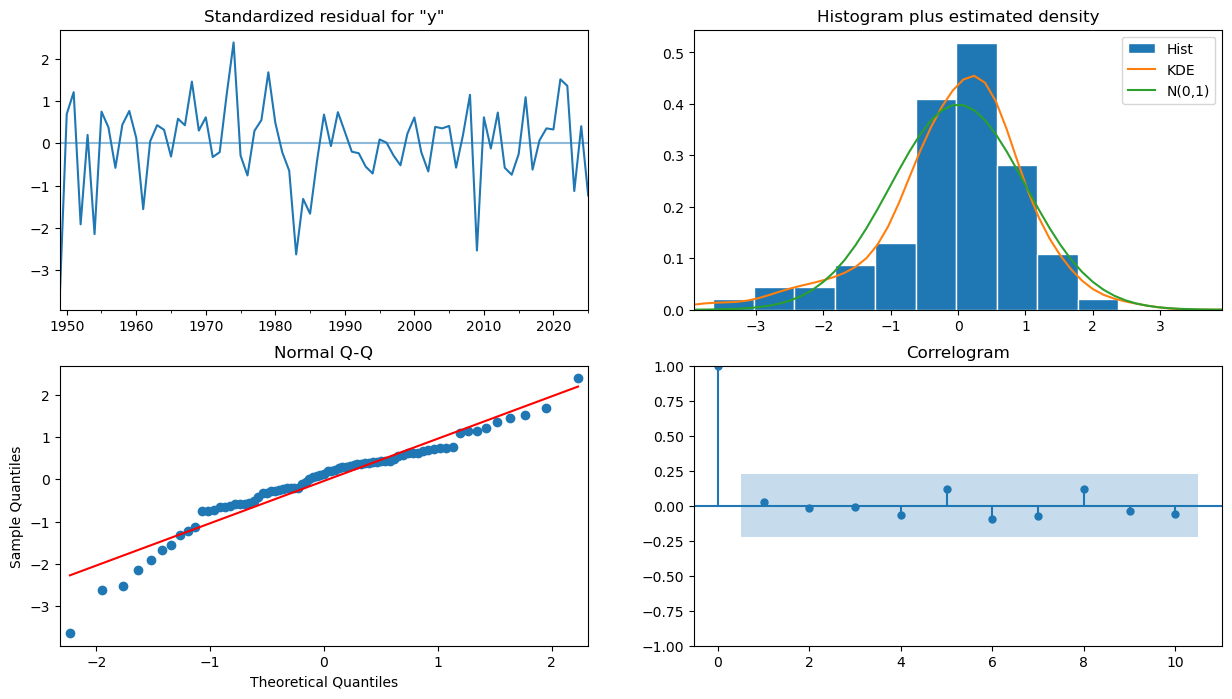

In [40]:
# Diagnostic plot of Model
mdl.plot_diagnostics(figsize = (15, 8))
plt.show()

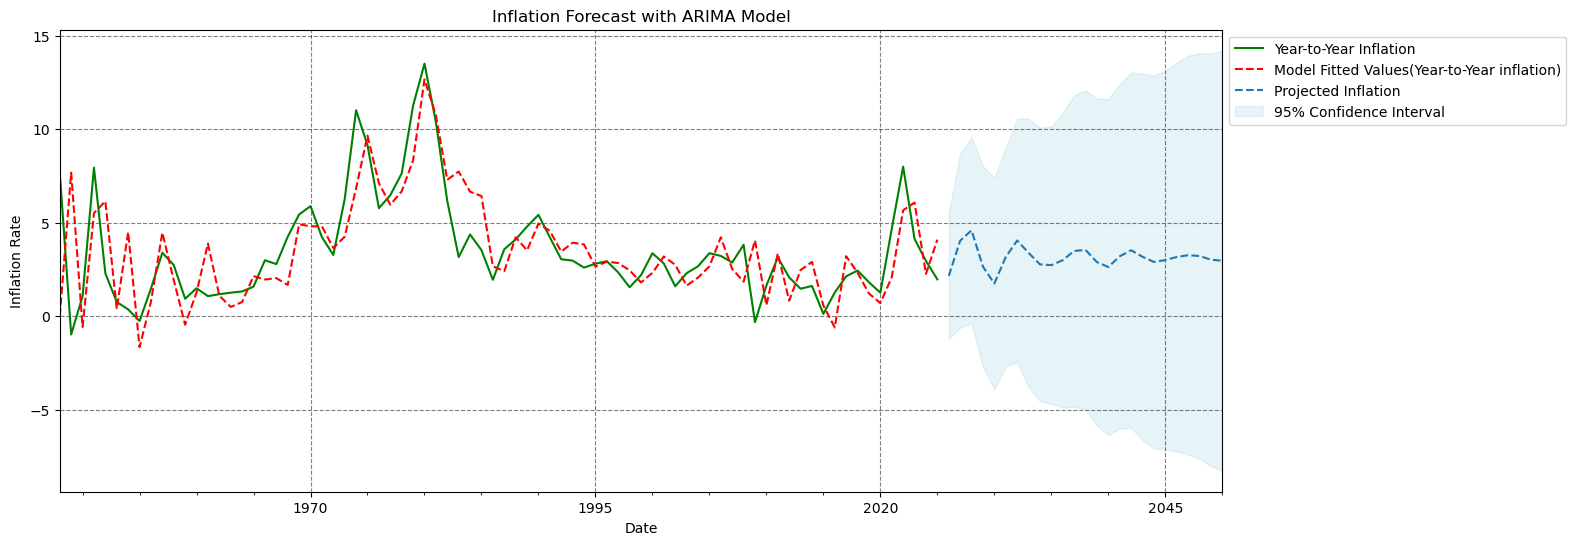

In [41]:
# Plot Projections
fig, ax = plt.subplots(figsize = (15, 6))

inflation.plot(ax=ax, color = 'green', label = "Year-to-Year Inflation")
mdl.fittedvalues.plot(ax = ax, color = 'red', linestyle = '--', label = "Model Fitted Values(Year-to-Year inflation)")

# Projected Values
mdl.get_forecast(steps = 25).predicted_mean.plot(ax=ax, linestyle = '--', label = "Projected Inflation")

# Confidence Intervals
conf_int = mdl.get_forecast(steps = 25).conf_int()

# Plot confidence interval shading
ax.fill_between(conf_int.index,
                conf_int.iloc[:, 0],  # lower bound
                conf_int.iloc[:, 1],  # upper bound
                color='lightblue', alpha=0.3, label="95% Confidence Interval")

ax.grid(alpha=0.5, color='k', linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Inflation Forecast with ARIMA Model")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")

plt.show()

## To finish, lets create a Seasonal ARIMA model(SARIMA) to forecast unemployment. Unemployment tends to be very cyclical so a SARIMA model will be very helpful to project when unemployment will peak and fall.

<Figure size 640x480 with 0 Axes>

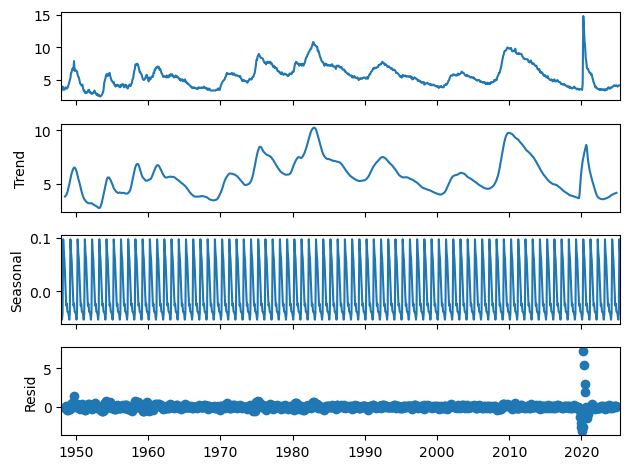

In [42]:
res = seasonal_decompose(unemp, period=12)

plt.figure()
res.plot()

plt.show()

(-6.358708577922716,
 2.505303348724468e-08,
 13,
 903,
 {'1%': -3.43761244359048,
  '5%': -2.8647460220589736,
  '10%': -2.568477099382028},
 1336.56421589933)


p-value < 0.05: True


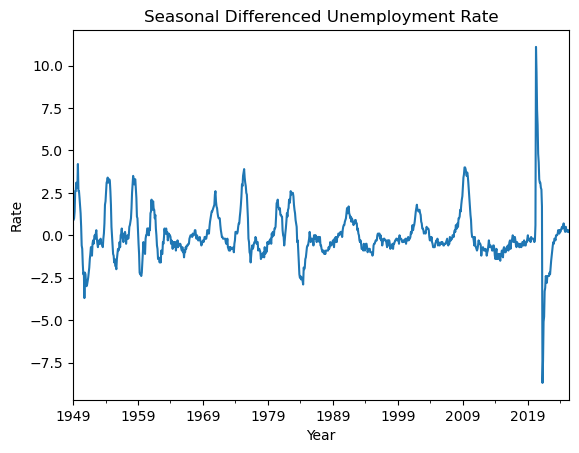

In [43]:
# Make data stationary by taking seasonal difference
unemp_seasonal_diff = unemp.diff(12).dropna()

# Check Stationarity
display(adfuller(unemp_seasonal_diff))

print(f"\np-value < 0.05: {adfuller(unemp_seasonal_diff)[1] < 0.05}")

unemp_seasonal_diff.plot(title = "Seasonal Differenced Unemployment Rate", ylabel = "Rate", xlabel="Year")
plt.show()

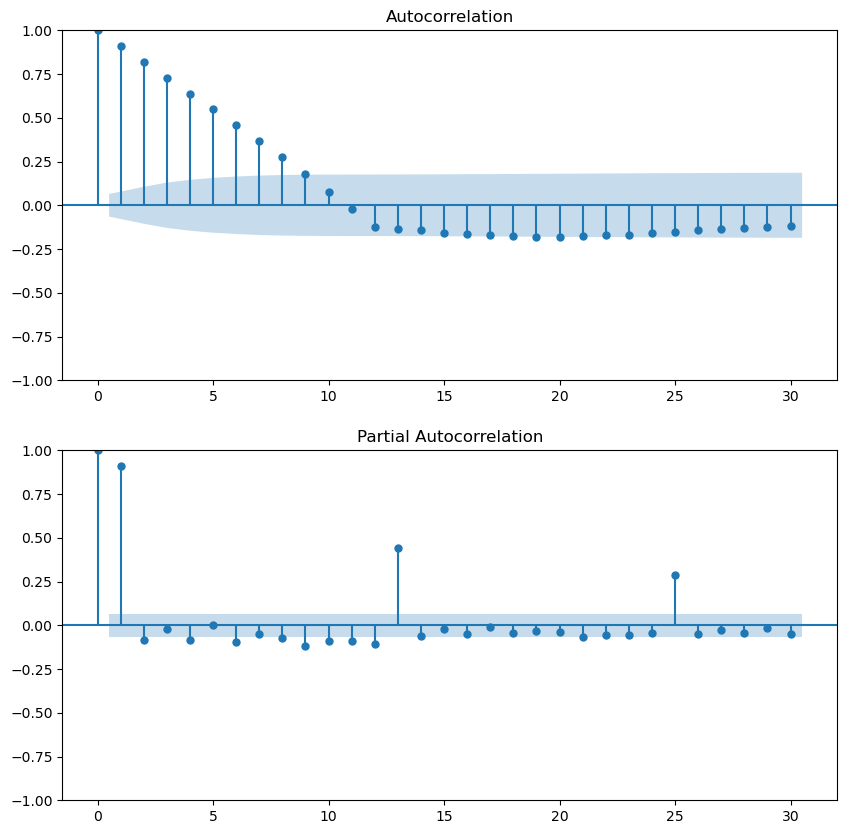

In [44]:
# Pacf and acf plots
fig, ax = plt.subplots(2,1, figsize=(10, 10))

plot_acf(unemp_seasonal_diff, ax=ax[0])
plot_pacf(unemp_seasonal_diff, ax=ax[1])

plt.show()

### NOTE: Unemployment data isnt stationary because it is seasonal and follows a predicatable trend

In [45]:
# Must Train for Covid Spike
train = unemp[:round(0.94*len(unemp))]
test = unemp[round(0.94*len(unemp)):]

display(train)
print()
display(test.head())

1948-01-01     3.4
1948-02-01     3.8
1948-03-01     4.0
1948-04-01     3.9
1948-05-01     3.5
              ... 
2020-05-01    13.2
2020-06-01    11.0
2020-07-01    10.2
2020-08-01     8.4
2020-09-01     7.8
Length: 873, dtype: float64

2020-10-01    6.9
2020-11-01    6.7
2020-12-01    6.7
2021-01-01    6.4
2021-02-01    6.2
dtype: float64

In [46]:
# Create a model based on model params
order = (1, 0, 1) 
seasonal_order = (2,1,1,12)

mdl_unemp = SARIMAX(train, order = order, seasonal_order=seasonal_order).fit()
mdl_unemp.summary()

C:\Users\ggpal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ggpal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  873
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -500.235
Date:                            Fri, 13 Jun 2025   AIC                           1012.470
Time:                                    13:11:08   BIC                           1041.019
Sample:                                01-01-1948   HQIC                          1023.399
                                     - 09-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9713      0.009    102.243      0.000       0.953       0.990
ma.L1          0.0522      0.012      4.491      0.000       0.029       0.075
ar.S.L12      -0.1286      0.128     -1.002      0.316      -0.380       0.123
ar.S.L24      -0.0934      0.134     -0.699      0.485      -0.355       0.168
ma.S.L12      -0.9090      0.096     -9.461      0.000      -1.097      -0.721
sigma2         0.1815      0.001    137.903      0.000       0.179       0.184
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           5617103.26
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               6.47   Skew:                            16.20
Prob(H) (two-sided):                  0.00   Kurtosis:                       397.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

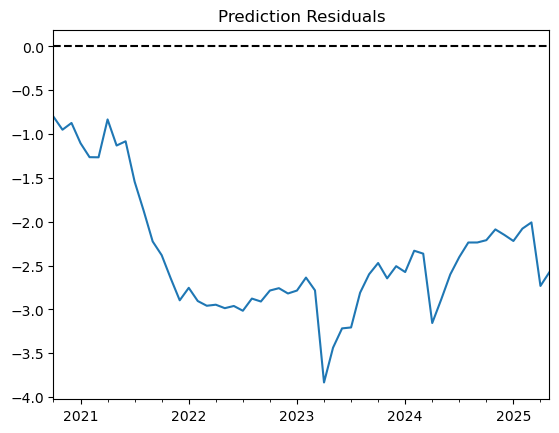

In [47]:
# Get predictions and residual values
preds = mdl_unemp.get_forecast(steps=len(test)).predicted_mean

# Residuals
(test-preds).plot(title = "Prediction Residuals")
plt.axhline(0, color = 'k', linestyle = '--')


plt.show()

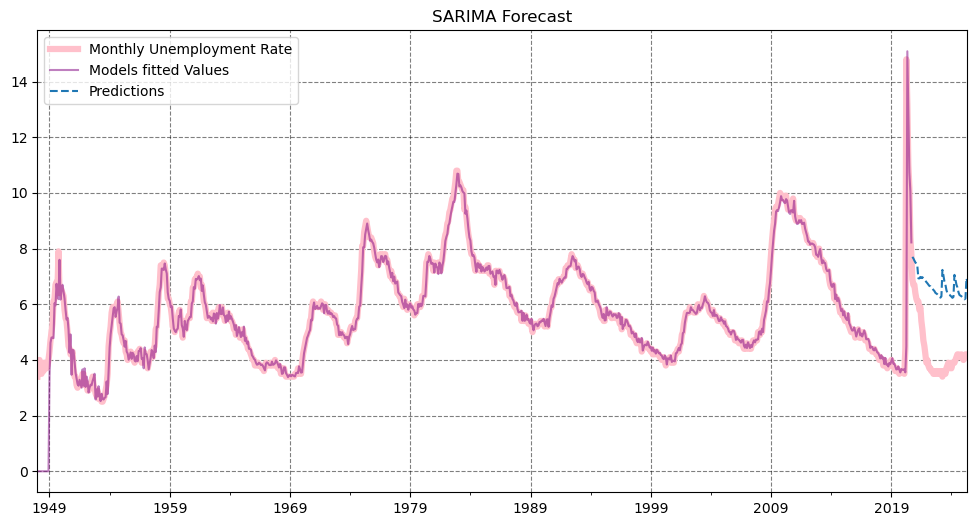

In [48]:
# Plot all data
plt.figure(figsize=(12, 6))
unemp.plot(color = 'pink', label = "Monthly Unemployment Rate", linewidth = 4.5)
mdl_unemp.fittedvalues.plot(color = 'purple', label = 'Models fitted Values', alpha = 0.5)
preds.plot(title = "SARIMA Forecast", label = "Predictions", linestyle = '--')



plt.legend()
plt.grid(alpha = 0.5, color = 'k', linestyle = '--')
plt.show()

In [49]:
# Check initial model performance
print(f"Mean Absolute Error: {np.mean(np.abs(preds - test))}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean((preds-test) ** 2))}")

Mean Absolute Error: 2.3808242564503947
Root Mean Squared Error: 2.4836426658998825
